In [215]:
from __future__ import division

import os
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

import scipy.io as sio
import scipy.stats as stats

### Helper fcns

In [216]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [217]:
def ThresholdClass(TestData):
    """Inputs: Dataframe containing AccMax and AccMin accelerations for test data
    Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
    TPR_thr=[]; FPR_thr=[]
    
    thrneg = np.sort(TestData[TestData['Falltype']==0]['AccMax']) #the feature value for all negatives
    thrneg = thrneg[::-1]
    N = len(thrneg)
    for fpr in np.linspace(0,1,50):
        if fpr == 1:
            thr = thrneg[-1]
        else:
            thr = thrneg[int(fpr*N)] #the threshold yielding fpr
            
        ThresPred = TestData.AccMax>thr
        Sens = len(ThresPred[(ThresPred==True) & (TestData.Falltype==1)])/len(ThresPred[TestData.Falltype==1])
        TPR_thr.append(Sens)
        FPR_thr.append(fpr)
    
    return TPR_thr, FPR_thr

In [218]:
def LOSOCV(X,y,data,groups):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    for train_index, test_index in subj.split(X, y, groups):
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index]
        
        #threshold method - tpr, fpr, auc
        tprT, fprT = ThresholdClass(Dte)
        tprT = np.asarray(tprT); fprT = np.asarray(fprT)
        roc_aucT = auc(fprT,tprT)
        
        #Random Forest
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        forest = RandomForestClassifier(n_estimators=100,random_state=10,warm_start=False,class_weight=None)    
        forest.fit(Xtr,ytr)
        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #threshold
        ind = np.argmax(tprT-fprT)
        SensT = tprT[ind]
        SpecT = 1-fprT[ind]
        
        TAUC_all.append(roc_aucT)
        Ttpr_all.append(tprT); Tfpr_all=fprT;
        TSens_all.append(SensT); TSpec_all.append(SpecT)
        
        #randomforest
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)
        
        print('AUC_T = %.4f, Sens_T = %.4f, Spec_T = %.4f'%(roc_aucT,SensT,SpecT)) #threshold
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    #summary results
    print(('mean AUC_T = %.3f (+/- %0.3f)')%(np.mean(TAUC_all),2*np.std(TAUC_all)))
    print(('mean Sens_T = %.3f (+/- %0.3f)')%(np.mean(TSens_all),2*np.std(TSens_all)))
    print(('mean Spec_T = %.3f (+/- %0.3f)')%(np.mean(TSpec_all),2*np.std(TSpec_all)))
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))


    results_T = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
    return results_T, results
#     return AUC_all, TAUC_all, fpr_all, tpr_all, Sens_all, Spec_all, TTPR_all, TFPR_all

In [219]:
#Dtr and D are the corresponding train and test dataframes

def EvaluateBySubject(Xtr,ytr,data,X,y,groups):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    TOpt_all = []; T90_all = []

    #select train features and train on the population in Xtr
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
    forest.fit(Xtr,ytr)
    
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    for train_index, test_index in subj.split(X, y, groups):
        
        Dte = data.iloc[test_index]
            
        tprT, fprT = ThresholdClass(Dte)
        tprT = np.asarray(tprT); fprT = np.asarray(fprT)
        roc_aucT = auc(fprT,tprT)
        
        Xte = X[test_index]
        yte = y[test_index]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        t_all = [] #for obtaining thresholds
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            t_all.append(t)
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec:
        #threshold
        ind = np.argmax(tprT-fprT)
        SensT = tprT[ind]
        SpecT = 1-fprT[ind]
        
        TAUC_all.append(roc_aucT)
        Ttpr_all.append(tprT); Tfpr_all=fprT;
        TSens_all.append(SensT); TSpec_all.append(SpecT)
        
        #randomforest
        ind = np.argmax(tpr-fpr,axis=0)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        ## Thresholds
        TOpt_all.append(t_all[ind])
        T90_all.append(t_all[np.argmin(abs(tpr-.90))])
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)
        
        print('AUC_T = %.4f, Sens_T = %.4f, Spec_T = %.4f'%(roc_aucT,SensT,SpecT)) #threshold
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    TOpt = np.mean(TOpt_all)
    T90 = np.mean(T90_all)
        
    #summary results
    print(('mean AUC_T = %.3f (+/- %0.3f)')%(np.mean(TAUC_all),2*np.std(TAUC_all)))
    print(('mean Sens_T = %.3f (+/- %0.3f)')%(np.mean(TSens_all),2*np.std(TSens_all)))
    print(('mean Spec_T = %.3f (+/- %0.3f)')%(np.mean(TSpec_all),2*np.std(TSpec_all)))
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))


    results_T = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all, 'TOpt':TOpt, 'T90':T90}
    return results_T, results

In [263]:
def HomeDataEval(Dtr,D,Threshold):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]; t_all=[]
    TTPR_all, TSpec_all = [], []
    FPCount_all, TFPCount_all = [], []
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    #train and test data as numpy arrays
    Xtr = Dtr.iloc[:,4:].as_matrix()
    ytr = Dtr.Falltype.as_matrix()
    X = D.iloc[:,4:].as_matrix()
    y = D.Falltype.as_matrix()

    #select train features and train on the population in Xtr
    Xtr = Xtr[:,indmax]
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
    forest.fit(Xtr,ytr)
    
    #split by subject for testing on X,y
    groups = D.SubjID.as_matrix()
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    
    for train_index, test_index in subj.split(X, y, groups):
        
        Dte = D.iloc[test_index]
            
        _, SpecT = ThresholdClass(Dte)
        TSpec_all.append(SpecT)
        
        Xte = X[test_index]
        yte = y[test_index]
        
        #selct test features
        Xte = Xte[:,indmax]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]
        
        #compute Sens and Spec
        Sens = sum((yscore>Threshold) & (yte==1)) / sum(yte==1); Spec = 1-sum((yscore>Threshold) & (yte==0)) / sum(yte==0)
        
        Spec_all.append(Spec)

    return Spec_all, TSpec_all

In [221]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '--'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [222]:
# def ThresholdClass(TrainData,TestData):
#     """Inputs: Dataframe containing AccMax and AccMin accelerations for both train and test data
#     Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
#     Max = TrainData.AccMax
#     Min = TrainData.AccMin
#     UFT = Max[TrainData.Falltype==1].min(axis=0)
#     LFT = Min[TrainData.Falltype==1].max(axis=0)
#     print UFT,LFT
#     ThresPred = (TestData.AccMax>UFT) & (TestData.AccMin<LFT)
#     Sens = len(ThresPred[(ThresPred==True) & (TestData.Falltype==1)])/len(ThresPred[TestData.Falltype==1])
#     Spec = len(ThresPred[(ThresPred==False) & (TestData.Falltype==0)])/len(ThresPred[TestData.Falltype==0])
    
#     return Sens, Spec

### Load the data (contains only activities clips below 2g)

In [223]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})

Healthy.loc[Healthy['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2

In [224]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.142730
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.130800
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.145240
3,1,1,1,4,-0.131590,0.012601,0.36066,-0.030360,0.038864,0.070713,...,2.0909,4.4104,1.371,0.51069,0.035452,0.046974,0.043586,0.073470,0.071604,0.098844
4,1,1,1,4,-0.174220,0.002581,0.33938,-0.049466,0.017201,0.068173,...,2.0293,4.1421,1.371,0.50332,0.045742,0.077608,0.067755,0.079449,0.131450,0.085266


In [225]:
print(len(Healthy))
print(len(Amp))

8616
2184


In [226]:
print(('N subjects Healthy: %s'%(len(Healthy.SubjID.unique()))))
print(('N subjects Amp: %s'%(len(Amp.SubjID.unique()))))
print(Healthy.Subjtype.unique())
print(Amp.Subjtype.unique())

N subjects Healthy: 10
N subjects Amp: 7
[1]
[0]


In [227]:
#Healthy
print(('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9])))
print(('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9])))

Nfalls = 6344
Nactivities = 2272


In [228]:
#Amp
print(('Nfalls = %s')%(len(Amp[Amp.Falltype<9])))
print(('Nactivities = %s')%(len(Amp[Amp.Falltype==9])))

Nfalls = 1877
Nactivities = 307


## Distribution of ACC Magnitude (for all clips)

In [229]:
MaxAcc = pd.read_csv('./Data/AccMax.csv',header=None)
MaxAcc = MaxAcc.rename(index=int,columns={0:'SubjType',1:'FallType',2:'AccMax'})

In [230]:
MaxAcc.head()

,SubjType,FallType,AccMax
0,1,1,3.2416
1,1,1,3.2021
2,1,1,3.2232
3,1,1,3.1034
4,1,1,3.1056


In [231]:
MaxAcc.SubjType.unique()

array([1, 0], dtype=int64)

In [232]:
# (MaxAcc['SubjType']==1)
print(MaxAcc.FallType.unique())

[1 0]


In [233]:
MaxAcc.loc[MaxAcc.AccMax > 5] = 5 #saturate the max acceleration

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


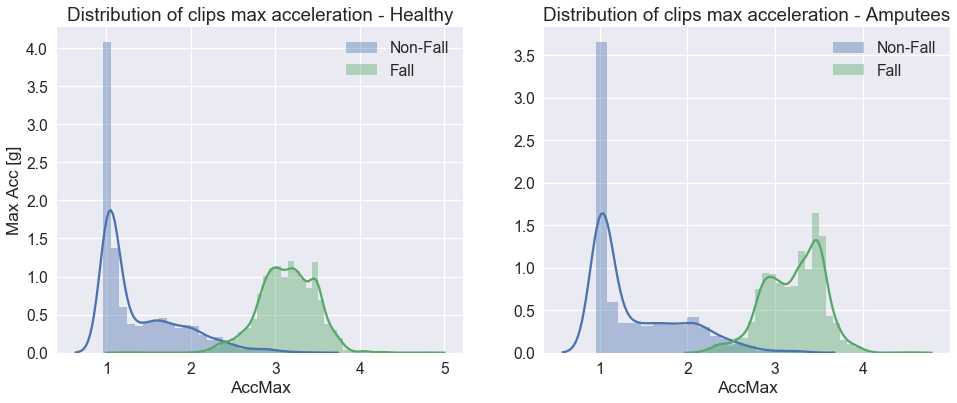

In [234]:
sns.set_context('talk',font_scale=1.2)
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
sns.distplot(MaxAcc[(MaxAcc['FallType']==0) & (MaxAcc['SubjType']==0)]['AccMax'],ax=ax1,label='Non-Fall')
sns.distplot(MaxAcc[(MaxAcc['FallType']==1) & (MaxAcc['SubjType']==0)]['AccMax'],ax=ax1,label='Fall')
plt.legend(); 
ax1.set_title('Distribution of clips max acceleration - Healthy'); ax1.set_ylabel('Max Acc [g]')
ax2 = fig.add_subplot(122)
sns.distplot(MaxAcc[(MaxAcc['FallType']==0) & (MaxAcc['SubjType']==1)]['AccMax'],ax=ax2,label='Non-Fall')
sns.distplot(MaxAcc[(MaxAcc['FallType']==1) & (MaxAcc['SubjType']==1)]['AccMax'],ax=ax2,label='Fall')
ax2.set_title('Distribution of clips max acceleration - Amputees'); ax1.set_ylabel('Max Acc [g]')
plt.legend(); 

# Feature selection on healthy data

In [235]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [236]:
print(Xtr.shape)
print(np.unique(ytr))
print(Xte.shape)
print(np.unique(yte))

(8616, 1211)
[0 1]
(2184, 1211)
[0 1]


In [237]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [238]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  9.02330177e-05   2.16146499e-05   8.05535733e-05 ...,   3.24668760e-05
   2.42084448e-05   4.19688498e-05]
[ 0.00027498  0.00014305  0.00030841 ...,  0.00015208  0.00016946
  0.00029378]


In [239]:
importance_norm = importance/np.max(importance)

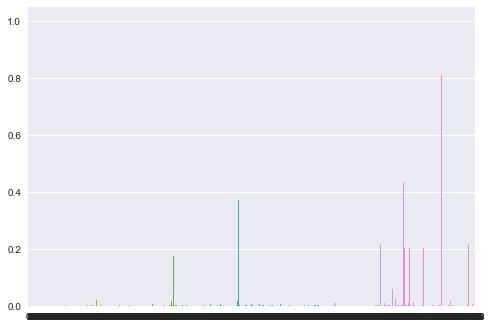

In [240]:
#using Seaborn
sns.set_context("notebook")
ax = sns.barplot(x=indices,y=importance_norm[indices])
plt.figure(figsize=(8,6))

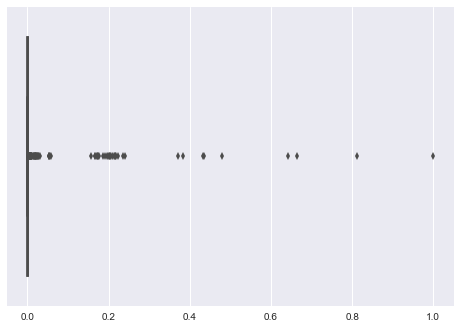

In [241]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [242]:
qc = np.percentile(importance_norm,[75])
print(1.5*qc)

[ 0.00131339]


In [243]:
# indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print(len(indmax))
print(indmax)

34
[ 336  338  347  394  519  546  569  570  593  686  839  945  946  948  949
  955 1009 1018 1020 1034 1046 1047 1071 1072 1095 1120 1121 1146 1166 1171
 1190 1194 1195 1200]


# LOSO CV on Healthy

In [244]:
#Load and normalize data from healthy and amputees
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Healthy.loc[Healthy['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
#binarize labels
XH = Healthy.iloc[:,4:].as_matrix()
yH = Healthy.Falltype.as_matrix()
yH[yH < 9] = 1
yH[yH == 9] = 0
scaler = preprocessing.StandardScaler().fit(XH) #define scaler
XH = scaler.transform(XH)
groupsH = Healthy.SubjID.as_matrix() #for CV

Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})
Amp = Amp[Amp.SubjID != 2] #drop subj 2
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
#binarize labels
XA = Amp.iloc[:,4:].as_matrix()
yA = Amp.Falltype.as_matrix()
yA[yA < 9] = 1
yA[yA == 9] = 0
XA = scaler.transform(XA)
groupsA = Amp.SubjID.as_matrix()

#Tot Features - #602 gyro features + 602 accelerometer
#use features subset (optimized on random forest)
# XH = XH[:,indmax]; XA = XA[:,indmax]

#use magnitude features only
indmax = np.linspace(336,355,20)
indmax = np.hstack([indmax,np.linspace(336,355,20)+602])
indmax = indmax.astype(int)
XH = XH[:,indmax]; XA = XA[:,indmax]

In [245]:
#Subjects with indoor and outdoor falls
print(np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique()))
print(np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique()))

[ 1  2  3  4  5  6  7  8  9 10]
[]


In [246]:
Healthy.shape

(8616, 1215)

In [247]:
HHresults_T, HHresults = LOSOCV(XH,yH,Healthy,groupsH)

AUC_T = 0.9991, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 0.9999, Sens = 1.0000, Spec = 0.9900

AUC_T = 0.9996, Sens_T = 0.9970, Spec_T = 0.9796
AUC = 0.9993, Sens = 0.9955, Spec = 0.9800

AUC_T = 0.9955, Sens_T = 0.9622, Spec_T = 0.9796
AUC = 0.9986, Sens = 0.9568, Spec = 1.0000

AUC_T = 0.9978, Sens_T = 1.0000, Spec_T = 0.9592
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.9968, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.9820, Sens_T = 0.9814, Spec_T = 0.8980
AUC = 0.9998, Sens = 0.9928, Spec = 1.0000

AUC_T = 0.9934, Sens_T = 0.9794, Spec_T = 0.9592
AUC = 0.9999, Sens = 1.0000, Spec = 0.9900

AUC_T = 0.9956, Sens_T = 0.9831, Spec_T = 0.9796
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.9787, Sens_T = 1.0000, Spec_T = 0.9184
AUC = 0.9928, Sens = 0.9630, Spec = 0.9800

AUC_T = 0.9895, Sens_T = 0.9584, Spec_T = 0.9592
AUC = 0.9892, Sens = 0.9900, Spec = 0.9900

mean AUC_T = 0.993 (+/- 0.014)
mean Sens_T = 0.986 (+/- 0.030)
mean Sp

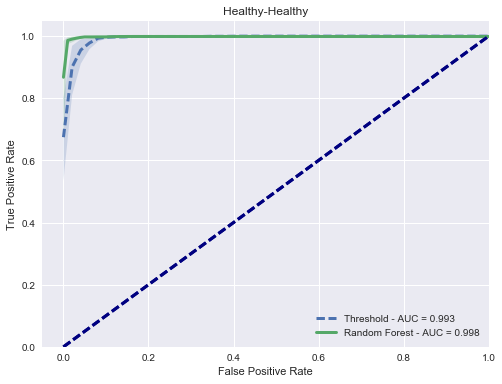

In [248]:
plt.figure(figsize=(8,6))
AX = plot_roc(HHresults_T['TPR'],HHresults_T['FPR'],np.mean(HHresults_T['AUC']),plotname='Threshold')
plot_roc(HHresults['TPR'],HHresults['FPR'],np.mean(HHresults['AUC']),ax=AX,plotname='Random Forest',col=current_palette[1])
AX.set_title('Healthy-Healthy')

# LOSO CV on Amputees

**Note: SubjID 2 does not have activities**

In [249]:
# #try SVM
# auc_all = []
# clf = SVC(kernel='linear',cache_size=800,probability=True,random_state=3)
# # clf = GradientBoostingClassifier(n_estimators=100,subsample=0.8)
# for train_index, test_index in subj.split(X, y, groups):
#     Xtr, Xte = X[train_index], X[test_index]
#     ytr, yte = y[train_index], y[test_index]
#     Xtr, Xte = Xtr[:,indmax], Xte[:,indmax] #selct features

#     #normalize data
#     scaler = preprocessing.StandardScaler().fit(Xtr)
#     scaler.transform(Xte)

#     #fit svm and compute ROC for each subject
#     clf.fit(Xtr,ytr)
#     ypred = clf.predict(Xte)
#     yscore = clf.predict_proba(Xte)[:,1]
#     fpr,tpr,thr = roc_curve(yte,yscore,pos_label=1)
#     roc_auc = auc(fpr, tpr)
#     auc_all.append(roc_auc)
#     print 'AUC = %.3f'%roc_auc

# print 'mean AUC = %.3f +/- %.3f'%(np.mean(auc_all),2*np.std(auc_all))

In [250]:
AAresults_T, AAresults = LOSOCV(XA,yA,Amp,groupsA)

AUC_T = 0.9494, Sens_T = 0.8834, Spec_T = 0.9184
AUC = 0.9911, Sens = 0.9955, Spec = 0.9200

AUC_T = 0.9994, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 0.9959, Sens = 1.0000, Spec = 0.9600

AUC_T = 0.9917, Sens_T = 0.9231, Spec_T = 1.0000
AUC = 0.9999, Sens = 0.9972, Spec = 1.0000

AUC_T = 0.9273, Sens_T = 0.8651, Spec_T = 0.8776
AUC = 0.9846, Sens = 0.9395, Spec = 0.9400

AUC_T = 0.8246, Sens_T = 0.7714, Spec_T = 0.7347
AUC = 0.9860, Sens = 0.9571, Spec = 0.9700

AUC_T = 0.9870, Sens_T = 0.9428, Spec_T = 0.9388
AUC = 0.9986, Sens = 0.9880, Spec = 0.9800

mean AUC_T = 0.947 (+/- 0.120)
mean Sens_T = 0.898 (+/- 0.142)
mean Spec_T = 0.908 (+/- 0.174)
mean AUC = 0.993 (+/- 0.012)
mean Sens = 0.980 (+/- 0.046)
mean Spec = 0.962 (+/- 0.052)


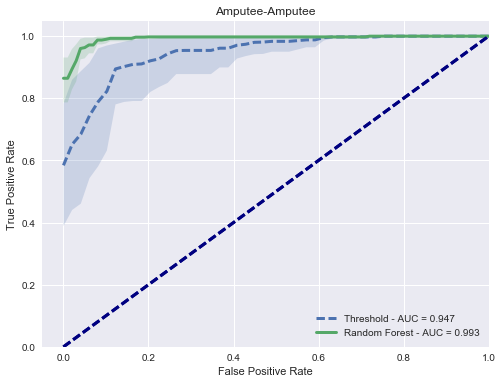

In [251]:
plt.figure(figsize=(8,6))
AX = plot_roc(AAresults_T['TPR'],AAresults_T['FPR'],np.mean(AAresults_T['AUC']),plotname='Threshold')
plot_roc(AAresults['TPR'],AAresults['FPR'],np.mean(AAresults['AUC']),ax=AX,plotname='Random Forest',col=current_palette[1])
AX.set_title('Amputee-Amputee')

# Healthy to Amputee w/ folds 

In [252]:
HAresults_T, HAresults = EvaluateBySubject(XH,yH,Amp,XA,yA,groupsA)

AUC_T = 0.9494, Sens_T = 0.8834, Spec_T = 0.9184
AUC = 0.9954, Sens = 0.9910, Spec = 0.9400

AUC_T = 0.9994, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 0.9962, Sens = 0.9884, Spec = 0.9500

AUC_T = 0.9917, Sens_T = 0.9231, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.9273, Sens_T = 0.8651, Spec_T = 0.8776
AUC = 0.9736, Sens = 0.9953, Spec = 0.9400

AUC_T = 0.8246, Sens_T = 0.7714, Spec_T = 0.7347
AUC = 0.9652, Sens = 0.8857, Spec = 0.9500

AUC_T = 0.9870, Sens_T = 0.9428, Spec_T = 0.9388
AUC = 0.9995, Sens = 0.9940, Spec = 0.9800

mean AUC_T = 0.947 (+/- 0.120)
mean Sens_T = 0.898 (+/- 0.142)
mean Spec_T = 0.908 (+/- 0.174)
mean AUC = 0.988 (+/- 0.027)
mean Sens = 0.976 (+/- 0.081)
mean Spec = 0.960 (+/- 0.045)


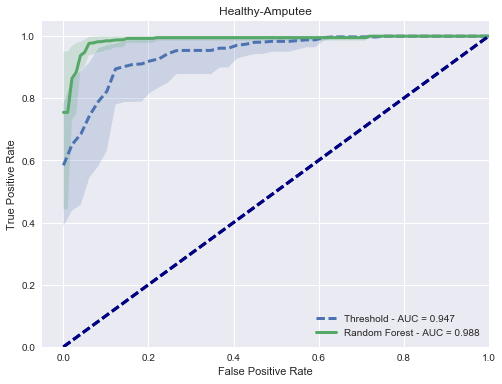

In [253]:
plt.figure(figsize=(8,6))
AX = plot_roc(HAresults_T['TPR'],HAresults_T['FPR'],np.mean(HAresults_T['AUC']),plotname='Threshold')
plot_roc(HAresults['TPR'],HAresults['FPR'],np.mean(HAresults['AUC']),ax=AX,plotname='Random Forest',col=current_palette[1])
AX.set_title('Healthy-Amputee')

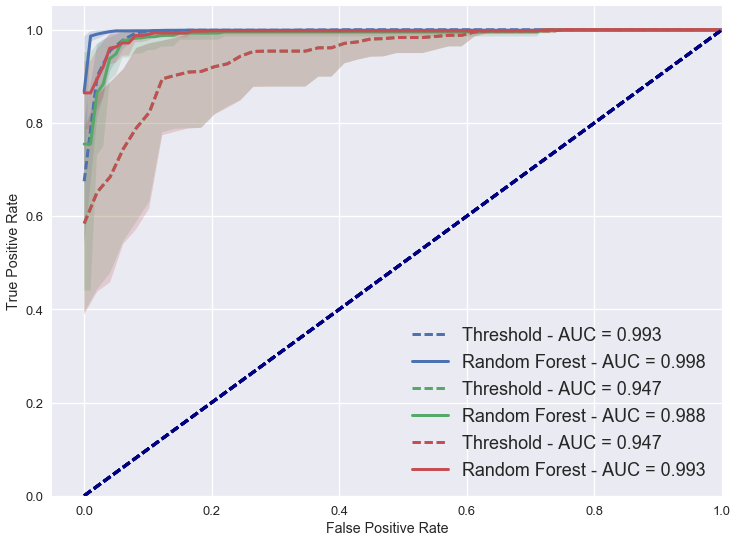

In [254]:
# AX.errorbar(fprmuAA,tprmuAA,xerr = fprerrAA,yerr = tprerrAA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)


population = ['Healthy-Healthy','Healthy-Amputee','Amputee-Amputee']
fig = plt.figure(figsize=(12,9))
ax1=None
sns.set_context('talk')
for index,value in enumerate(zip(population,[HHresults_T, HAresults_T, AAresults_T],[HHresults, HAresults, AAresults])):
    results_T = value[1]
    results = value[2]
    ax1 = plot_roc(results_T['TPR'],results_T['FPR'],np.mean(results_T['AUC']),plotname='Threshold',col=current_palette[index])
    plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=ax1,plotname='Random Forest',col=current_palette[index])
    
ax1.legend(loc='lower right',fontsize = 18)

In [255]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig2.jpg')

In [256]:
ax.get_legend_handles_labels()

([], [])

# Location Analysis

## Train on all locs (Healthy) and test on each location (Waist, Pocket and Hand) for amputees

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.8957, Sens_T = 0.8795, Spec_T = 0.8571
AUC = 0.9384, Sens = 1.0000, Spec = 0.8900

AUC_T = 0.7640, Sens_T = 0.7143, Spec_T = 0.7347
AUC = 0.9748, Sens = 0.9714, Spec = 0.9400

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

mean AUC_T = 0.943 (+/- 0.178)
mean Sens_T = 0.932 (+/- 0.214)
mean Spec_T = 0.932 (+/- 0.205)
mean AUC = 0.986 (+/- 0.046)
mean Sens = 0.995 (+/- 0.021)
mean Spec = 0.972 (+/- 0.085)
AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.9510, Sens_T = 0.9167, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC_T = 0.8406, Sens_T = 1.0000, Spec_T = 0.7347
AUC = 1.0000, Sens = 1.

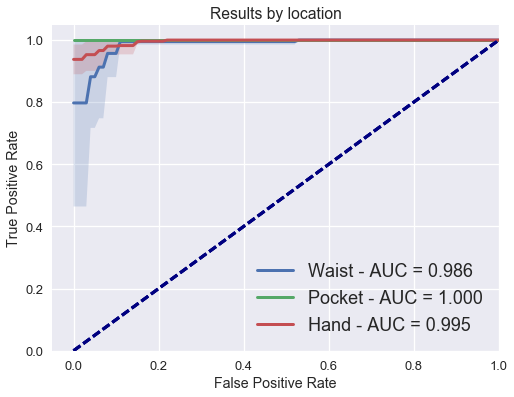

In [257]:
sns.set_context('talk')
locs = [1,2,3]
fig = plt.figure(figsize=(8,6))
ax1=None

#remove subjects with no falls for some locations
Amp = Amp[(Amp.SubjID!=1)|(Amp.Loc!=2)]
Amp = Amp[(Amp.SubjID!=6)|((Amp.Loc!=2)&(Amp.Loc!=3))]

locAUC=[]

for l,name in zip(locs,['Waist','Pocket','Hand']):
    
    #filter amputees data (test data)
    Ampdata = Amp[Amp.Loc==l]
    #binarize labels
    Xloc = Ampdata.iloc[:,4:].as_matrix()
    yloc = Ampdata.Falltype.as_matrix()
    Xloc = scaler.transform(Xloc)
    Xloc = Xloc[:,indmax]
    groupsLoc = Ampdata.SubjID.as_matrix()
    
    results_T, results = EvaluateBySubject(XH,yH,Ampdata,Xloc,yloc,groupsLoc)

#     locAUC.append(AUC_all_HA)
    
#     TTPR_allHA = np.asarray(TTPR_allHA)
#     TFPR_allHA = np.asarray(TFPR_allHA)

#     tprmu = np.mean(TTPR_allHA)
#     tprerr = np.std(TTPR_allHA)/math.sqrt(len(TTPR_allHA))*1.96
#     fprmu = np.mean(TFPR_allHA)
#     fprerr = np.std(TFPR_allHA)/math.sqrt(len(TFPR_allHA))*1.96
    
#     ax1 = fig.add_subplot(2,2,l) #uncomment this line to generate subplots
    ax1 = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax1,plotname=name,col=current_palette[l-1])
#     plot_roc(results_T['TPR'],results_T['FPR'],np.mean(results_T['AUC']),ax=ax1,plotname='Threshold',col=current_palette[l-1])

ax1.set_title('Results by location')
ax1.legend(loc=4,fontsize = 18)

In [258]:
# [t_value, p_value] = stats.ttest_ind(locAUC[0],locAUC[1],equal_var=False)
# print('Waist vs. Pocket %0.3f'%(p_value))

# [t_value, p_value] = stats.ttest_ind(locAUC[0],locAUC[2],equal_var=False)
# print('Waist vs. Hand %0.3f'%(p_value))

# [t_value, p_value] = stats.ttest_ind(locAUC[1],locAUC[2],equal_var=False)
# print('Pocket vs. Hand %0.3f'%(p_value))

In [259]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig3.jpg')
fig.savefig('./Figs/Fig3.tif')

# Home data analysis

In [260]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Homedata = pd.read_csv('./Data/HomeData.csv',header=None)
Homedata = Homedata.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Homedata.Falltype = 0
Amp.loc[Amp.Falltype<9,'Falltype'] = 1
Amp.loc[Amp.Falltype==9,'Falltype'] = 0

In [261]:
for s in Homedata.SubjID.unique():
    Homedata = pd.concat([Amp[(Amp.SubjID==s) & (Amp.Falltype==1)],Homedata],axis=0)
    
XHome = Homedata.iloc[:,4:].as_matrix()
yHome = Homedata.Falltype.as_matrix()
XHome = scaler.transform(XHome)
XHome = XHome[:,indmax]
groupsHome = Homedata.SubjID.as_matrix()

In [266]:
Spec_all, TSpec_all = HomeDataEval(Healthy,Homedata,HAresults['TOpt'])
print(Spec_all)

[0.93693693693693691, 0.96367410482615468, 0.89976689976689972]


In [267]:
Spec_all, TSpec_all = HomeDataEval(Healthy,Homedata,HAresults['T90'])
print(Spec_all)

[0.963963963963964, 0.98962117280747275, 0.93939393939393945]


In [268]:
results_T, results = EvaluateBySubject(XH,yH,Homedata,XHome,yHome,groupsHome)

AUC_T = 0.9627, Sens_T = 0.9910, Spec_T = 0.8367
AUC = 0.9927, Sens = 0.9776, Spec = 0.9600

AUC_T = 0.7434, Sens_T = 0.6286, Spec_T = 0.8367
AUC = 0.9682, Sens = 0.9571, Spec = 0.9200

AUC_T = 0.9713, Sens_T = 0.9759, Spec_T = 0.8776
AUC = 0.9776, Sens = 0.9729, Spec = 0.9300

mean AUC_T = 0.892 (+/- 0.211)
mean Sens_T = 0.865 (+/- 0.335)
mean Spec_T = 0.850 (+/- 0.038)
mean AUC = 0.980 (+/- 0.020)
mean Sens = 0.969 (+/- 0.017)
mean Spec = 0.937 (+/- 0.034)


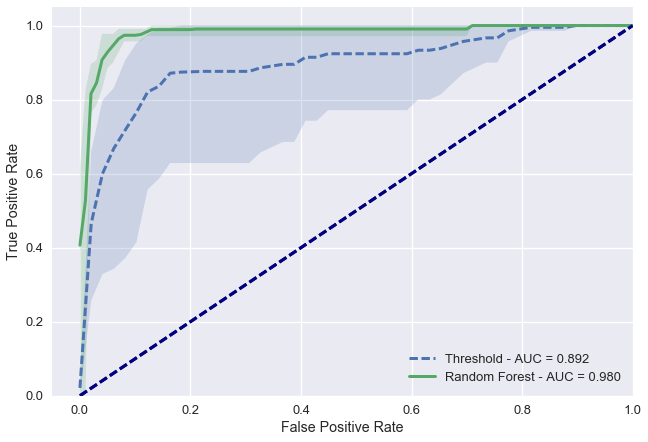

In [269]:
ax1 = plot_roc(results_T['TPR'],results_T['FPR'],np.mean(results_T['AUC']),plotname='Threshold')
plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=ax1,plotname='Random Forest',col=current_palette[1])

In [1224]:
fig = ax2.get_figure()
fig.savefig('./Figs/Fig4.jpg')
fig.savefig('./Figs/Fig4.tif')

In [991]:
for i in range(0,3):
    print(np.argmin(abs(tpr_all_HA[i]-.95)))
    

4
9
6


# Stacking 
1) Optimize 4 different classifiers (using LOSO CV)

2) Use stacking for final prediction

In [322]:
#normalize data from healthy and amputees
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Healthy.loc[Healthy['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
#binarize labels
XH = Healthy.iloc[:,4:].as_matrix()
yH = Healthy.Falltype.as_matrix()
yH[yH < 9] = 1
yH[yH == 9] = 0
scaler = preprocessing.StandardScaler().fit(XH) #define scaler
XH = scaler.transform(XH)
groupsH = Healthy.SubjID.as_matrix() #for CV

Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})
Amp = Amp[Amp.SubjID != 2] #drop subj 2
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
XA = Amp.iloc[:,4:].as_matrix()
yA = Amp.Falltype.as_matrix()
yA[yA < 9] = 1
yA[yA == 9] = 0
XA = scaler.transform(XA)
groupsA = Amp.SubjID.as_matrix()

#use features subset
XH = XH[:,indmax]; XA = XA[:,indmax]

In [323]:
#try SVM
auc_all = []
clf = SVC(kernel='linear',cache_size=800,probability=True,random_state=3)
X = XH; y = yH; groups = groupsH

for train_index, test_index in subj.split(X, y, groups):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
#     Xtr, Xte = Xtr[:,indmax], Xte[:,indmax] #selct features

    #fit svm and compute ROC for each subject
    clf.fit(Xtr,ytr)
    ypred = clf.predict(Xte)
    yscore = clf.predict_proba(Xte)[:,1]
    fpr,tpr,thr = roc_curve(yte,yscore,pos_label=1)
#     roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(yte,yscore)
    auc_all.append(roc_auc)
    print 'AUC = %.3f'%roc_auc

print 'mean AUC = %.3f +/- %.3f'%(np.mean(auc_all),2*np.std(auc_all))

AUC = 1.000
AUC = 0.995
AUC = 0.982
AUC = 1.000
AUC = 1.000
AUC = 0.999
AUC = 1.000
AUC = 1.000
AUC = 0.997
AUC = 0.998
mean AUC = 0.997 +/- 0.011


In [324]:
models = [[ RandomForestClassifier(random_state=2), {'n_estimators': [10,50,100]}, "Random Forest"]]

models.append([GradientBoostingClassifier(random_state=2), {'n_estimators':[10,50,100], 'max_depth':[2,4]}, "GradientBoost" ])

models.append([SVC(kernel='linear',cache_size=800,random_state=2), {'C':[0.01,0.1,1]}, "SVM" ])


In [254]:
#optimize parameters of 3 models using LOSOCV on healthy
from sklearn.metrics import make_scorer
auc_scorer = make_scorer(roc_auc_score)
start_time = time.time()
best_estimator = []

groups = groupsH
X = XH; y = yH

for model in models:
    clf = GridSearchCV(model[0],model[1],cv=subj.split(X, y, groups),n_jobs=-1,scoring='average_precision')
    clf.fit(X,y)
    best_params = clf.best_params_
    best_estimator.append(clf.best_estimator_)
    means = clf.cv_results_['mean_test_score']
    print('Best Estimator ',clf.best_estimator_)
    print('\n')
    print("Best parameters for ", model[2], " : ", best_params)
    print('Best score %.3f'%(clf.best_score_))
    print('\n')

end_time = time.time()
print end_time

('Best Estimator ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False))


('Best parameters for ', 'Random Forest', ' : ', {'n_estimators': 100})
Best score 0.999


('Best Estimator ', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))


('Best parameters for ', 'GradientBoost', ' : ', {'n_e

In [325]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2),
          SVC(kernel='linear',C=0.1,cache_size=800,probability=True)]
model_name = ['Random Forest','Gradient Boosting','SVM']

In [384]:
#fit base-level and meta-level classifier on healthy and test on amputees
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []

    #CV to train base level clf and obtain train features for meta-level
    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

#     skf = StratifiedKFold(n_splits=5,random_state=99)
    for clf,name in zip(models,model_name):

        print name
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print 'base-level classifiers trained'
    print Xtrain_meta.shape
    print ytrain_meta.shape
    
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
    print 'training meta-classifier'
    metaclf = LogisticRegression()
    metaclf.fit(Xtrain_meta,ytrain_meta)
    meta_classifier.append(metaclf)
    print 'meta-classifier trained'

    return base_classifiers, meta_classifier

In [385]:
base_classifiers, meta_classifier = fit_stacking(XH,yH,groupsH)
meta_classifier = meta_classifier[0]

Random Forest
Gradient Boosting
SVM
base-level classifiers trained
(4890, 3)
(4890,)
training meta-classifier
meta-classifier trained


In [410]:
def predict_stacking(X,y,groups):

    
    AUC_meta = []; AUC = []; Sens_meta = []; Sens = []; Spec_meta = []; Spec = []
    
    for train, test in subj.split(X, y, groups):
        
        X_test = X[test,:]; y_test = y[test]
        Xtest_meta = np.zeros((len(y_test),len(models))) #stores the base clf predictions for current subj
        auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
        Sens_base = np.empty( (len(models),1) )
        Spec_base = np.empty( (len(models),1) )
        i = 0 #clf index

        #1. base-classifiers predictions
        for clf,name in zip(base_classifiers,model_name):
            Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_test, Xtest_meta[:,i], pos_label=1)
            ind = np.argmax(tpr-fpr,axis=0)
            Sens_base[i] = tpr[ind]; Spec_base[i] = 1-fpr[ind]
            auc_base[i] = auc(fpr, tpr)
            i+=1
        print 'best base-clf %s, auc = %.3f, Sens = %.3f, Spec  = %.3f' % (model_name[np.argmax(auc_base)],
                                                                           np.max(auc_base),np.max(Sens_base),
                                                                           np.max(Spec_base))
        
        #add extra meta features
        metastd = np.std(Xtest_meta,axis=1)
        metastd = np.expand_dims(metastd,axis=0)
        Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)

        #2. meta-level clf predictions (final prediction)
        yscore_meta = meta_classifier.predict_proba(Xtest_meta)[:,1]
        ypred_meta = meta_classifier.predict(Xtest_meta)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, yscore_meta, pos_label=1)
        ind = np.argmax(tpr-fpr,axis=0)
        Sens_meta = tpr[ind]; Spec_meta = 1-fpr[ind]
        print 'auc meta = %.3f, Sens = %.3f, Spec = %.3f\n' % (auc(fpr, tpr),Sens_meta,Spec_meta)
        AUC_meta.append(auc(fpr, tpr))
               
#     results_meta = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
#     results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
#     return results_T, results



In [411]:
predict_stacking(XA,yA,groupsA)

best base-clf Random Forest, auc = 0.997, Sens = 0.996, Spec  = 0.974
auc meta = 0.998, Sens = 0.955, Spec = 1.000

best base-clf SVM, auc = 0.999, Sens = 1.000, Spec  = 0.984
auc meta = 0.998, Sens = 0.997, Spec = 0.984

best base-clf Random Forest, auc = 1.000, Sens = 1.000, Spec  = 1.000
auc meta = 1.000, Sens = 1.000, Spec = 1.000

best base-clf SVM, auc = 0.993, Sens = 0.991, Spec  = 0.964
auc meta = 0.990, Sens = 1.000, Spec = 0.929

best base-clf Random Forest, auc = 0.987, Sens = 0.986, Spec  = 1.000
auc meta = 0.988, Sens = 0.957, Spec = 0.952

best base-clf Gradient Boosting, auc = 1.000, Sens = 1.000, Spec  = 1.000
auc meta = 1.000, Sens = 0.997, Spec = 1.000



In [338]:
XA.shape

(1844, 40)

In [308]:
scaler = preprocessing.StandardScaler().fit(X)
scaler.mean_

array([-0.02106472,  0.00690687, -0.02369422, ...,  0.12807407,
        0.13417161,  0.10672752])

In [311]:
#amputees data
Amp = Amp[Amp.SubjID != 2] #drop subj 2
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.sort(np.unique(groups)))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

print X.mean(axis=0)
X = scaler.transform(X)
print X.mean(axis=0)

(1844,)
[1 3 4 5 6 7]
[ 0.02779509 -0.06354123  0.0235777  ...,  0.57252773  0.58725874
  0.38234075]
[ 0.22685219 -0.31176972  0.23156042 ...,  1.72593638  1.93739343
  2.37722612]


In [316]:
scaler.mean_

array([-0.02106472,  0.00690687, -0.02369422, ...,  0.12807407,
        0.13417161,  0.10672752])

In [265]:
Xtrain_meta, base_classifiers = fit_stacking(X,y)

Random Forest
Gradient Boosting
SVM


AttributeError: predict_proba is not available when  probability=False